In [113]:
import os
import scipy
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

In [114]:
mdata = [scipy.io.loadmat(os.path.join('data', 'mitchell', file)) for file in os.listdir('data/mitchell')]

### Filter voxel overlap

In [115]:
participants = []
for participant in mdata:
    voxel_ids = list(map(tuple, participant['meta'][0][0][7]))
    voxel_activations = participant['data']
    participants.append((voxel_ids, voxel_activations))

In [116]:
common_voxel_ids = set(participants[0][0])
for ids, _ in participants[1:]:
    common_voxel_ids.intersection_update(ids)

In [118]:
mdata_common_voxels = []
for participant in tqdm(participants):
    voxel_ids = participant[0]
    trials_activation = participant[1]
    common_activations = []
    for activations in trials_activation:
        activation_dict = {voxel_id: activation for voxel_id, activation in zip(voxel_ids, activations[0][0])}
        activations_list = []
        voxel_id_list = []
        for voxel_id in common_voxel_ids:
            activations_list.append(activation_dict[voxel_id])
            voxel_id_list.append(voxel_id)
        common_activations.append((voxel_id_list, np.array(activations_list)))
    mdata_common_voxels.append(common_activations)

100%|██████████| 9/9 [00:21<00:00,  2.43s/it]


### Voxels atlas

In [6]:
vox_atlas = scipy.io.loadmat("../mitchel_matlab/functions/ccbi_aal_atlas.mat")

In [8]:
vox_atlas.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Y', 'vinv', 'label', 'id'])

In [13]:
vox_atlas['Y'].shape

(91, 109, 91)

### Create voxels-nouns matrix (21764 x 60)

In [220]:
arrays = {}
for i in range(len(mdata)):
    for item in mdata[i]['info'][0]:
        word = item[2][0]
        if word in arrays:
            arrays[word].append(mdata_common_voxels[i][np.where(mdata[i]['info'][0] == item)[0][0]][1])
        else:
            arrays[word] = [mdata_common_voxels[i][np.where(mdata[i]['info'][0] == item)[0][0]][1]]

In [221]:
averaged_arrays = {}
for word in arrays.keys():
    averaged_arrays[word] = np.mean(np.stack(arrays[word]), axis=0)

In [222]:
df_voxel_noun = pd.DataFrame.from_dict(averaged_arrays)

In [224]:
df_voxel_noun.head()

,refrigerator,barn,bell,key,window,screwdriver,church,desk,cow,knife,...,door,leg,carrot,watch,table,chimney,bed,fly,dog,telephone
0,-0.012514,-0.099705,0.062205,0.160798,0.089062,-0.026115,0.089495,0.117547,0.051390,0.148600,...,-0.000671,-0.034956,0.075208,-0.080399,-0.095861,-0.124346,0.152353,0.249923,0.104739,-0.082348
1,0.004073,0.150665,-0.041381,-0.032574,0.012020,-0.043047,-0.046725,0.231704,-0.043682,0.189475,...,0.007445,-0.190556,-0.038704,-0.103024,-0.143510,-0.138647,0.075204,-0.120406,0.009444,-0.063714
2,0.339468,0.165295,0.224444,0.189013,0.027443,0.224441,0.125367,0.150629,0.228366,0.397830,...,-0.008815,0.016563,0.149002,-0.066596,0.063831,0.131591,0.515392,0.223411,0.153883,-0.085430
3,-0.027404,-0.120602,0.141460,0.013487,0.087629,-0.110773,0.023360,-0.059483,0.120359,0.231212,...,-0.033112,-0.194160,-0.198997,-0.058925,-0.218875,-0.123676,0.127954,-0.156444,0.030061,-0.132323
4,0.166217,0.023788,0.200193,0.083213,0.103442,-0.200677,-0.006194,-0.090887,0.011963,0.211302,...,0.000114,0.048326,0.073113,-0.025460,-0.135332,-0.134097,0.240360,-0.004976,0.140009,-0.204470


### Create nouns-sem_featuers matrix (60 x 25)

In [225]:
raw_file = os.path.join("data","mitchell_semantic_raw.txt")
semantic_features = {}
with open(raw_file, 'r') as f:
    lines = f.readlines()
    word = None
    for line in lines:
        if len(line) >= 5:
            if "Features for" in line:
                if word and len(semantic_features[word]['features']) < 25: del semantic_features[word] 
                word = line.split("<a name=\"")[1].split("\"")[0]
                semantic_features[word] = { "features": [], "values": []}
            elif word:
                feature_name = line.split()[0]
                val = float(line.split("(")[1].split(")")[0])
                semantic_features[word]["features"].append(feature_name)
                semantic_features[word]["values"].append(val)

In [226]:
df_noun_feature = pd.DataFrame()
for noun, info in semantic_features.items():
    temp_df = pd.DataFrame({
        'feature': info['features'],
        'value': info['values'],
        'noun': noun})
    df_noun_feature = pd.concat([df_noun_feature, temp_df], ignore_index=True)

df_noun_feature = df_noun_feature.pivot(columns='feature', values='value', index='noun')

In [227]:
df_noun_feature.head()

feature,approach,break,clean,drive,eat,enter,fear,fill,hear,lift,...,push,ride,rub,run,say,see,smell,taste,touch,wear
noun,,,,,,,,,,,,,,,,,,,,,
airplane,0.048,0.028,0.019,0.023,0.024,0.056,0.019,0.032,0.066,0.072,...,0.024,0.918,0.000,0.052,0.201,0.221,0.005,0.000,0.048,0.001
ant,0.023,0.017,0.132,0.010,0.062,0.016,0.005,0.005,0.016,0.016,...,0.000,0.015,0.006,0.944,0.156,0.198,0.000,0.006,0.005,0.003
apartment,0.009,0.064,0.238,0.070,0.012,0.210,0.002,0.080,0.021,0.024,...,0.002,0.007,0.000,0.075,0.093,0.200,0.036,0.000,0.002,0.000
arch,0.060,0.047,0.185,0.075,0.035,0.032,0.024,0.054,0.012,0.053,...,0.004,0.018,0.007,0.129,0.244,0.474,0.000,0.000,0.127,0.015
arm,0.019,0.432,0.021,0.071,0.008,0.024,0.005,0.026,0.007,0.548,...,0.084,0.010,0.030,0.103,0.450,0.132,0.001,0.002,0.206,0.048


### Regression

In [228]:
from sklearn.linear_model import LinearRegression

In [229]:
model = LinearRegression()

In [230]:
voxel_coordinates = mdata_common_voxels[0][0][0]

In [231]:
X = df_noun_feature
y = df_voxel_noun

In [232]:
df_coefficients = pd.DataFrame(index=range(y.shape[0]), columns=X.columns)
df_coefficients.index.name = 'voxel'

In [233]:
for i in tqdm(range(y.shape[0])):
    model.fit(X, y.iloc[i])
    df_coefficients.iloc[i] = model.coef_
df_coefficients['coordinates'] = voxel_coordinates

100%|██████████| 17326/17326 [00:10<00:00, 1645.45it/s]


In [513]:
df_coefficients.head()

feature,approach,break,clean,drive,eat,enter,fear,fill,hear,lift,...,ride,rub,run,say,see,smell,taste,touch,wear,coordinates
voxel,,,,,,,,,,,,,,,,,,,,,
0,0.316118,0.062101,0.304672,0.107914,0.179471,-0.175867,0.237096,0.149849,0.404479,0.096848,...,0.193677,-1.528674,0.024,0.034793,0.044276,-1.26423,0.043618,0.30875,0.081344,"(15, 32, 18)"
1,0.23307,-0.038993,0.014711,0.111085,0.088122,-0.300206,-0.17827,0.447787,1.079586,-0.094468,...,-0.066421,-2.351172,0.084264,-0.018474,-0.079446,-1.450164,-0.165458,0.001592,0.04555,"(7, 35, 10)"
2,0.000378,0.006736,-0.067433,0.088367,0.285909,0.144354,-0.183911,0.371651,-0.333128,0.059831,...,0.296393,-1.319472,0.19821,0.100911,0.040214,-0.499136,-0.170172,0.202427,0.096943,"(22, 11, 9)"
3,0.053474,-0.059124,0.090103,-0.057654,0.098876,-0.307052,0.394507,0.175287,0.713036,-0.087754,...,0.015435,-2.634882,-0.175633,0.052169,-0.053108,-0.846864,0.020704,-0.011033,0.115031,"(11, 18, 11)"
4,0.322472,-0.126816,0.33309,0.083121,0.215777,-0.17154,-0.199109,0.238076,0.803062,0.041603,...,0.105573,-0.744051,-0.043098,-0.049931,-0.016026,-0.426312,-0.155756,0.257844,0.026681,"(10, 40, 5)"


### Brain images

In [343]:
import nibabel as nib
from nilearn import plotting, image
from nilearn.plotting import plot_glass_brain, plot_anat
from nilearn.datasets import load_mni152_template

In [391]:
volume_shape = vox_atlas['Y'].shape
brain_volume = np.zeros(volume_shape)

In [503]:
for index, row in df_coefficients.iterrows():
    coordinates = row['coordinates']
    x, y, z = coordinates[0], coordinates[1], coordinates[2]
    brain_volume[x, y, z] = row['see']

In [510]:
voxel_size = 3
affine = np.array([
    [-voxel_size, 0, 0, 75],  # Adjust the translation components to center the image better
    [0, voxel_size, -0.2, -110], # Adjust these values to fine-tune the position
    [0, 1.2, voxel_size, -40],
    [0, 0, 0, 1]
])

In [511]:
nii_image = nib.Nifti1Image(brain_volume, affine=affine)

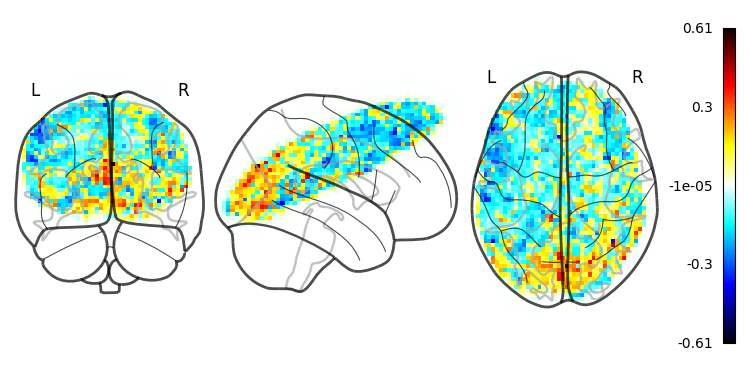

In [512]:
plot_glass_brain(nii_image, display_mode='ortho', colorbar=True, plot_abs=False)